In [36]:
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, kstest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
# Load data
df = pd.read_csv('D:\PENS-EEPIS\SDT A Semester 2 2025\Pemrosesan Data\CBF\Cleaning & Merge Data/top_hits.csv')
if df is None or df.empty:
    raise ValueError("DataFrame is empty or not loaded correctly.")
print("Data loaded successfully!")
print(f"Shape: {df.shape}")


<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16352\2865313545.py:5: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv('D:\PENS-EEPIS\SDT A Semester 2 2025\Pemrosesan Data\CBF\Cleaning & Merge Data/top_hits.csv')


Data loaded successfully!
Shape: (161, 6)


 =============================== 
 1. EXPLORATORY DATA ANALYSIS
 
 ===============================


📊 Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   song         161 non-null    object
 1   artis        161 non-null    object
 2   album        161 non-null    object
 3   viewed       161 non-null    int64 
 4   tahun_rilis  161 non-null    int64 
 5   genre        161 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.7+ KB
None

📈 Descriptive Statistics:
             viewed  tahun_rilis
count  1.610000e+02   161.000000
mean   7.456916e+07  2014.869565
std    1.168230e+08     9.163194
min    5.937000e+03  1993.000000
25%    4.602730e+06  2006.000000
50%    1.941777e+07  2018.000000
75%    9.099892e+07  2024.000000
max    5.684447e+08  2025.000000

🔍 Missing Values:
Series([], dtype: int64)

🔁 Duplicate Rows:
Number of duplicates: 0


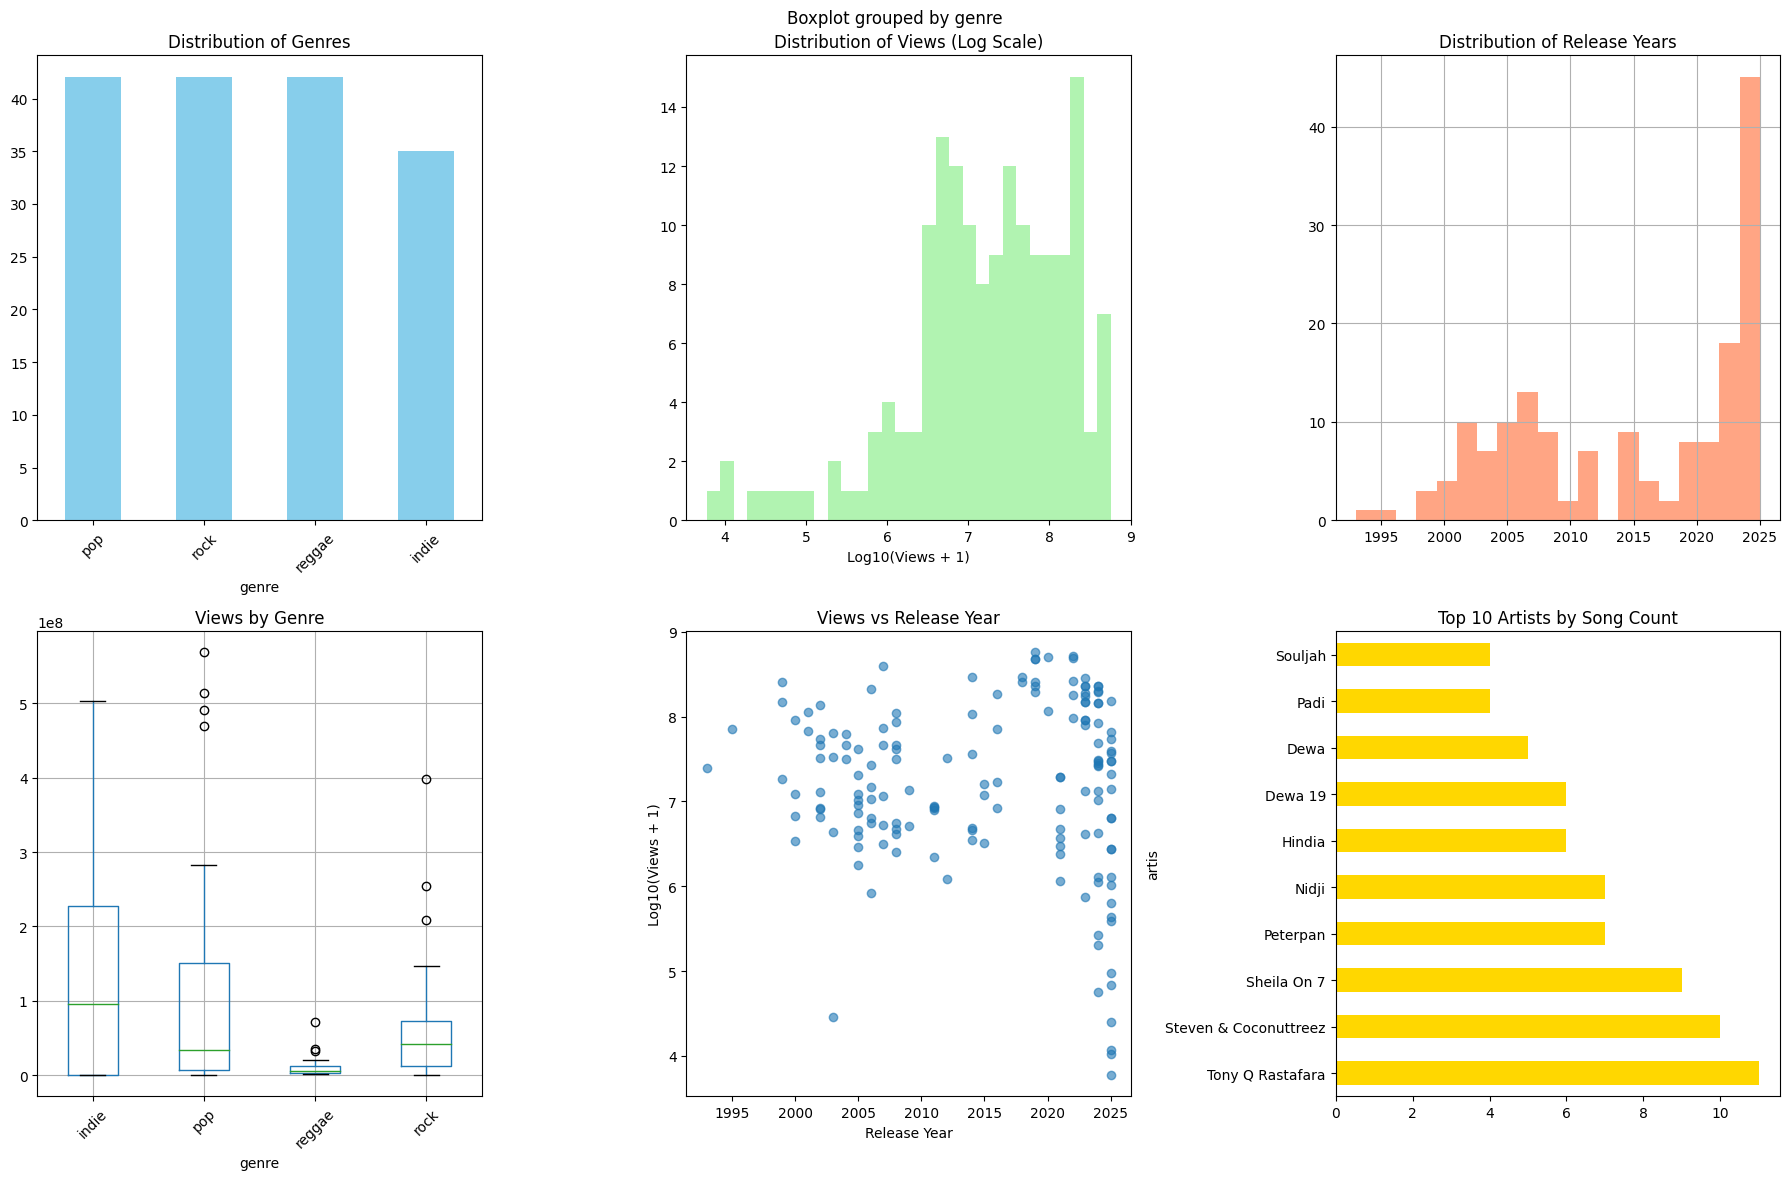

In [ ]:

import matplotlib.pyplot as plt

def eda_analysis(df):
    print("\nBasic Information:")
    print(df.info())
    
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    print("\nMissing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    print("\nDuplicate Rows:")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicates: {duplicates}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Distribution of genres
    df['genre'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Distribution of Genres')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Distribution of views (log scale)
    axes[0,1].hist(np.log10(df['viewed'] + 1), bins=30, color='lightgreen', alpha=0.7)
    axes[0,1].set_title('Distribution of Views (Log Scale)')
    axes[0,1].set_xlabel('Log10(Views + 1)')
    
    # Distribution of release years
    df['tahun_rilis'].hist(bins=20, ax=axes[0,2], color='coral', alpha=0.7)
    axes[0,2].set_title('Distribution of Release Years')
    
    # Box plot of views by genre
    df.boxplot(column='viewed', by='genre', ax=axes[1,0])
    axes[1,0].set_title('Views by Genre')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Views vs Year scatter plot
    axes[1,1].scatter(df['tahun_rilis'], np.log10(df['viewed'] + 1), alpha=0.6)
    axes[1,1].set_title('Views vs Release Year')
    axes[1,1].set_xlabel('Release Year')
    axes[1,1].set_ylabel('Log10(Views + 1)')
    
    # Top 10 artists by song count
    top_artists = df['artis'].value_counts().head(10)
    top_artists.plot(kind='barh', ax=axes[1,2], color='gold')
    axes[1,2].set_title('Top 10 Artists by Song Count')
    
    plt.tight_layout()
    plt.show()

eda_analysis(df)

 ===============================
 
 2. FEATURE ANALYSIS

 ===============================


🧪 Chi-square Test (Genre vs High Popularity):
Chi-square statistic: 37.5667
P-value: 0.0000
Significant relationship: Yes

📊 ANOVA Test (Views across Genres):
F-statistic: 9.0591
P-value: 0.0000
Significant difference: Yes


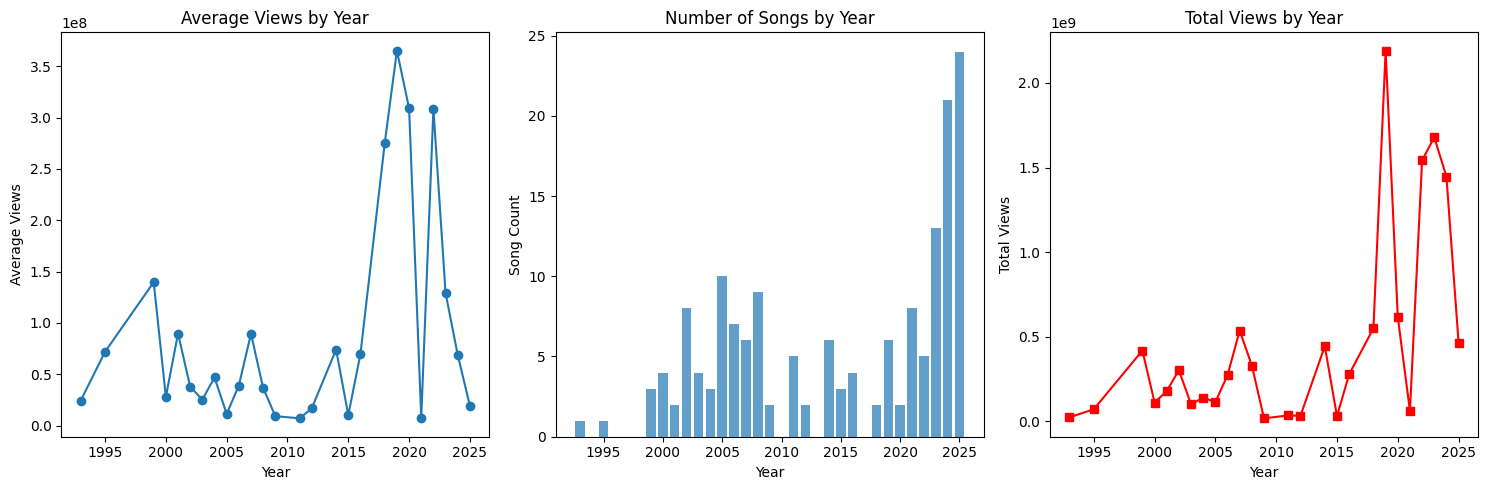


🎯 Outlier Detection (IQR Method):
Number of outliers: 19
Percentage of outliers: 11.80%


In [39]:
def feature_analysis(df):
    # Chi-square test: Genre vs High Popularity
    median_views = df['viewed'].median()
    df['high_popularity'] = (df['viewed'] > median_views).astype(int)
    
    contingency_table = pd.crosstab(df['genre'], df['high_popularity'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n🧪 Chi-square Test (Genre vs High Popularity):")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significant relationship: {'Yes' if p_value < 0.05 else 'No'}")
    
    # ANOVA: Views across genres
    groups = [group['viewed'].values for name, group in df.groupby('genre')]
    f_stat, p_val = f_oneway(*groups)
    
    print(f"\n📊 ANOVA Test (Views across Genres):")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_val:.4f}")
    print(f"Significant difference: {'Yes' if p_val < 0.05 else 'No'}")
    
    # Time series analysis
    yearly_stats = df.groupby('tahun_rilis')['viewed'].agg(['mean', 'count', 'sum']).reset_index()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(yearly_stats['tahun_rilis'], yearly_stats['mean'], marker='o')
    plt.title('Average Views by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Views')
    
    plt.subplot(1, 3, 2)
    plt.bar(yearly_stats['tahun_rilis'], yearly_stats['count'], alpha=0.7)
    plt.title('Number of Songs by Year')
    plt.xlabel('Year')
    plt.ylabel('Song Count')
    
    plt.subplot(1, 3, 3)
    plt.plot(yearly_stats['tahun_rilis'], yearly_stats['sum'], marker='s', color='red')
    plt.title('Total Views by Year')
    plt.xlabel('Year')
    plt.ylabel('Total Views')
    
    plt.tight_layout()
    plt.show()
    
    # Outlier detection using IQR
    Q1 = df['viewed'].quantile(0.25)
    Q3 = df['viewed'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df['viewed'] < lower_bound) | (df['viewed'] > upper_bound)]
    print(f"\n🎯 Outlier Detection (IQR Method):")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")

feature_analysis(df)



 ===============================
 
 3. CATEGORICAL DATA ANALYSIS

 ===============================



📊 Cardinality Analysis:
Song: 156 unique values
Artis: 71 unique values
Album: 113 unique values
Genre: 4 unique values

🔝 Top 5 Values for Each Category:

Song:
song
Bunga Maaf          2
Nina                2
Rumah Ke Rumah      2
everything u are    2
Mangu               2
Name: count, dtype: int64

Artis:
artis
Tony Q Rastafara         11
Steven & Coconuttreez    10
Sheila On 7               9
Peterpan                  7
Nidji                     7
Name: count, dtype: int64

Album:
album
Breakthru                     5
Sebuah Nama, Sebuah Cerita    5
The Other Side                5
Cintailah Cinta               4
Good Atmosphere               4
Name: count, dtype: int64

Genre:
genre
pop       42
rock      42
reggae    42
indie     35
Name: count, dtype: int64


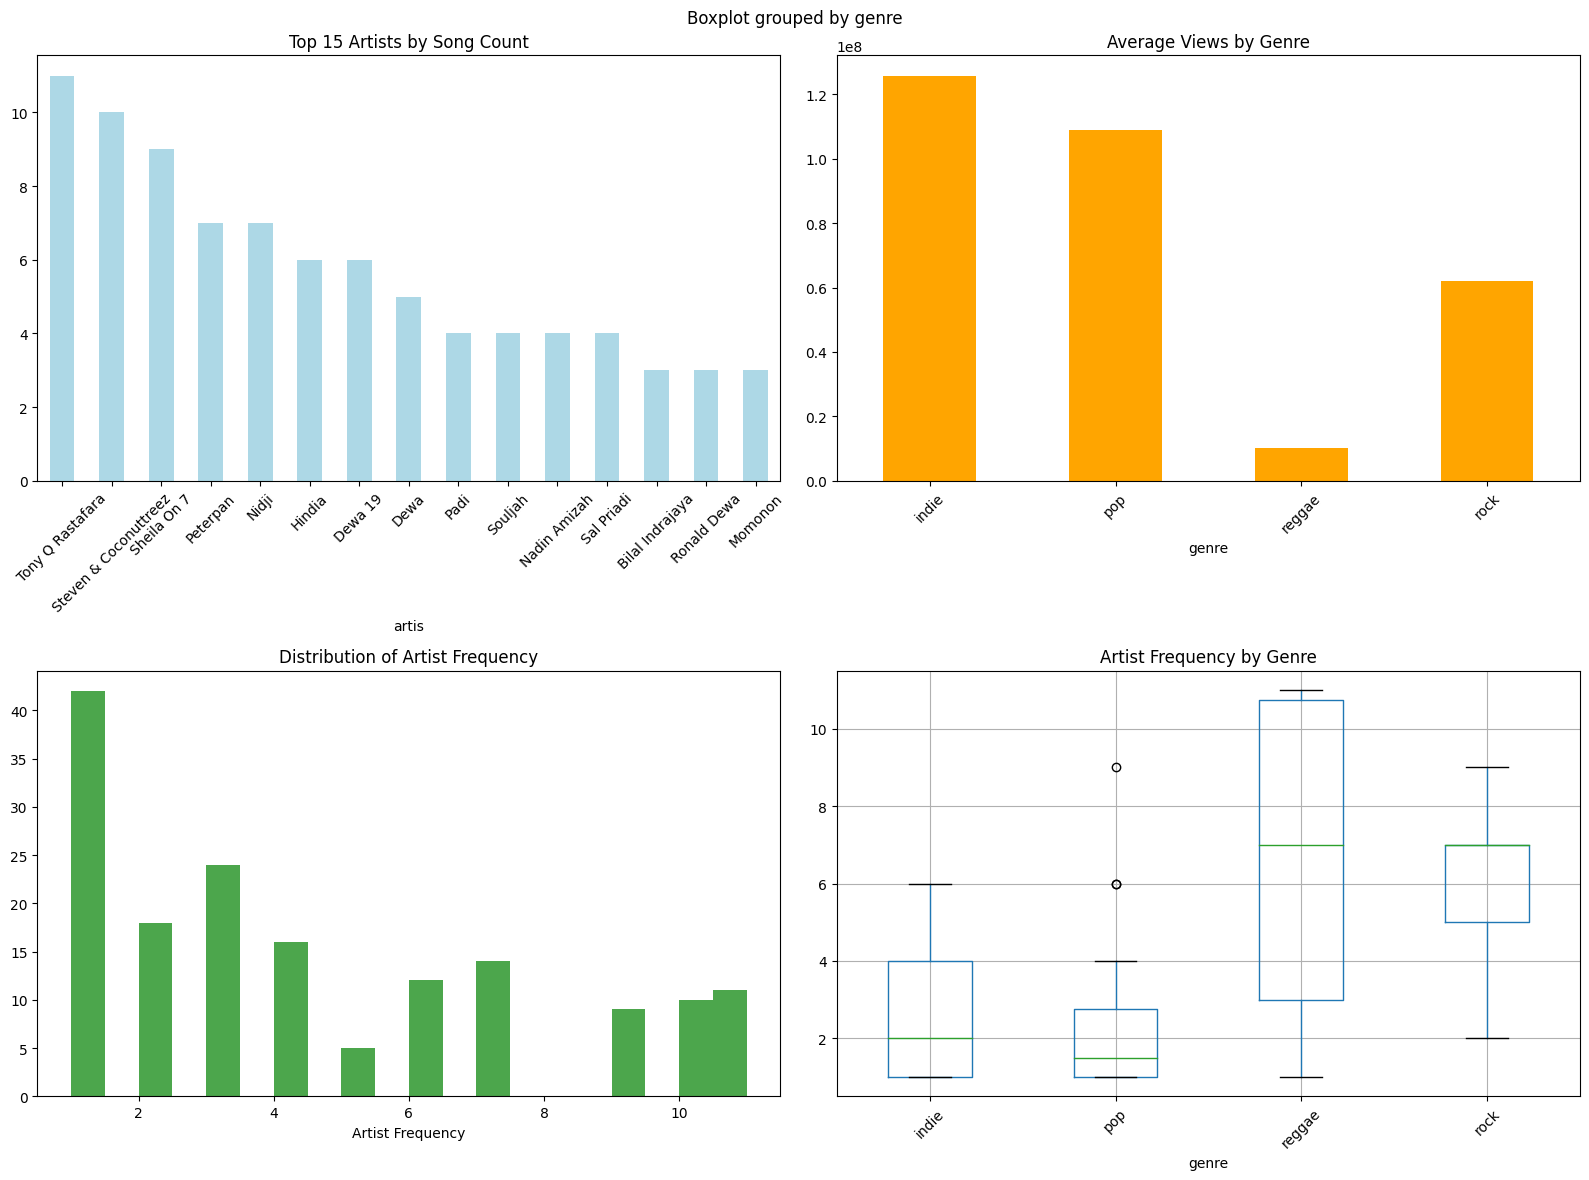

In [ ]:
def categorical_analysis(df):
    # Frequency encoding for artists
    artist_freq = df['artis'].value_counts()
    df['artist_frequency'] = df['artis'].map(artist_freq)
    
    # Target encoding for genre
    genre_mean_views = df.groupby('genre')['viewed'].mean()
    df['genre_mean_views'] = df['genre'].map(genre_mean_views)
    
    # Cardinality analysis
    print("\nCardinality Analysis:")
    categorical_cols = ['song', 'artis', 'album', 'genre']
    for col in categorical_cols:
        unique_count = df[col].nunique()
        print(f"{col.capitalize()}: {unique_count} unique values")
    
    # Top values for each categorical column
    print("\n🔝 Top 5 Values for Each Category:")
    for col in categorical_cols:
        print(f"\n{col.capitalize()}:")
        print(df[col].value_counts().head())
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Artist frequency distribution
    artist_freq.head(15).plot(kind='bar', ax=axes[0,0], color='lightblue')
    axes[0,0].set_title('Top 15 Artists by Song Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Genre encoding comparison
    genre_stats = df.groupby('genre').agg({
        'viewed': ['mean', 'count'],
        'artist_frequency': 'mean'
    }).round(2)
    
    genre_stats.columns = ['Avg_Views', 'Song_Count', 'Avg_Artist_Freq']
    genre_stats['Avg_Views'].plot(kind='bar', ax=axes[0,1], color='orange')
    axes[0,1].set_title('Average Views by Genre')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Distribution of artist frequency
    axes[1,0].hist(df['artist_frequency'], bins=20, color='green', alpha=0.7)
    axes[1,0].set_title('Distribution of Artist Frequency')
    axes[1,0].set_xlabel('Artist Frequency')
    
    # Genre vs Artist Frequency
    df.boxplot(column='artist_frequency', by='genre', ax=axes[1,1])
    axes[1,1].set_title('Artist Frequency by Genre')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

categorical_analysis(df)


In [41]:
!pip install wordcloud -q

In [42]:
import sys
!{sys.executable} -m pip install wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


 ===============================

 4. TEXT ANALYSIS
 
 ===============================

In [43]:
import wordcloud
from wordcloud import WordCloud


Most Common Words in Song Titles:
aku: 10
cinta: 8
i: 6
you: 6
rumah: 6
kita: 5
yang: 5
di: 5
to: 4
bunga: 4
sampai: 4
u: 4
semua: 3
mata: 3
the: 3
ke: 3
nina: 3
tak: 3
cantik: 3
ada: 3

Most Common Bigrams:
'i want': 2
'rumah ke': 2
'ke rumah': 2
'bunga maaf': 2
'jatuh cinta': 2
'cinta di': 2
'kita usahakan': 2
'everything u': 2
'u are': 2
'don t': 2

📏 Title Length Statistics:
Average character length: 14.83
Average word count: 2.58


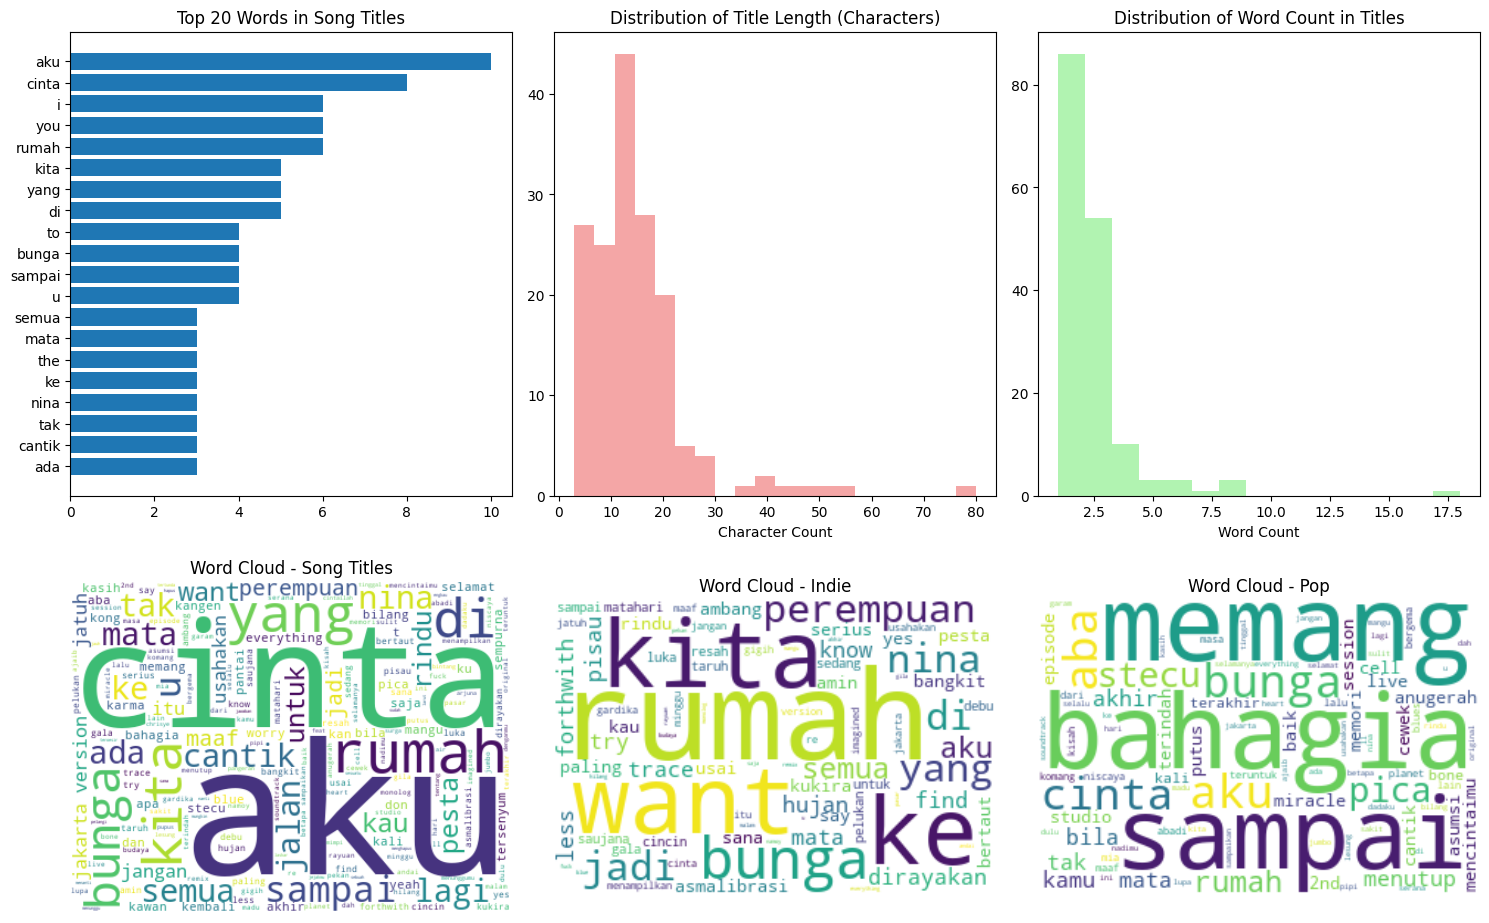

In [44]:
import re
def text_analysis(df):
    # Clean song titles
    def clean_text(text):
        if pd.isna(text):
            return ""
        # Remove special characters and normalize
        text = re.sub(r'[^\w\s]', ' ', str(text))
        text = re.sub(r'\s+', ' ', text)
        return text.lower().strip()
    
    df['song_clean'] = df['song'].apply(clean_text)
    
    # N-gram analysis
    all_titles = ' '.join(df['song_clean'].dropna())
    words = all_titles.split()
    
    # Word frequency
    word_freq = Counter(words)
    common_words = word_freq.most_common(20)
    
    print("\nMost Common Words in Song Titles:")
    for word, freq in common_words:
        print(f"{word}: {freq}")
    
    # Bigram analysis
    bigrams = [' '.join([words[i], words[i+1]]) for i in range(len(words)-1)]
    bigram_freq = Counter(bigrams)
    
    print("\nMost Common Bigrams:")
    for bigram, freq in bigram_freq.most_common(10):
        print(f"'{bigram}': {freq}")
    
    # Title length analysis
    df['title_length'] = df['song'].astype(str).apply(len)
    df['word_count'] = df['song_clean'].apply(lambda x: len(x.split()) if x else 0)
    
    print(f"\n📏 Title Length Statistics:")
    print(f"Average character length: {df['title_length'].mean():.2f}")
    print(f"Average word count: {df['word_count'].mean():.2f}")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Word frequency
    plt.subplot(2, 3, 1)
    words_df = pd.DataFrame(common_words, columns=['word', 'frequency'])
    plt.barh(words_df['word'], words_df['frequency'])
    plt.title('Top 20 Words in Song Titles')
    plt.gca().invert_yaxis()
    
    # Title length distribution
    plt.subplot(2, 3, 2)
    plt.hist(df['title_length'], bins=20, alpha=0.7, color='lightcoral')
    plt.title('Distribution of Title Length (Characters)')
    plt.xlabel('Character Count')
    
    # Word count distribution
    plt.subplot(2, 3, 3)
    plt.hist(df['word_count'], bins=15, alpha=0.7, color='lightgreen')
    plt.title('Distribution of Word Count in Titles')
    plt.xlabel('Word Count')
    
    # Word cloud
    plt.subplot(2, 3, 4)
    if all_titles:
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(all_titles)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud - Song Titles')
    
    # Genre-specific word clouds
    genres = df['genre'].unique()
    for i, genre in enumerate(genres[:2]):  # Show first 2 genres
        plt.subplot(2, 3, 5+i)
        genre_titles = ' '.join(df[df['genre'] == genre]['song_clean'].dropna())
        if genre_titles:
            wc = WordCloud(width=300, height=200, background_color='white').generate(genre_titles)
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud - {genre.title()}')
    
    plt.tight_layout()
    plt.show()

text_analysis(df)


 ===============================

 5. SIMILARITY ANALYSIS PREPARATION

 ===============================



Feature Scaling Comparison:

StandardScaler:
Mean: [0. 0. 0. 0.]
Std: [1. 1. 1. 1.]
Min: [-0.64  -2.394 -1.036 -1.177]
Max: [4.241 1.109 1.997 6.483]

MinMaxScaler:
Mean: [0.131 0.683 0.342 0.154]
Std: [0.205 0.285 0.33  0.131]
Min: [0. 0. 0. 0.]
Max: [1. 1. 1. 1.]

RobustScaler:
Mean: [ 0.638 -0.174  0.236  0.183]
Std: [1.348 0.507 0.549 1.005]
Min: [-0.225 -1.389 -0.333 -1.   ]
Max: [6.355 0.389 1.333 6.7  ]


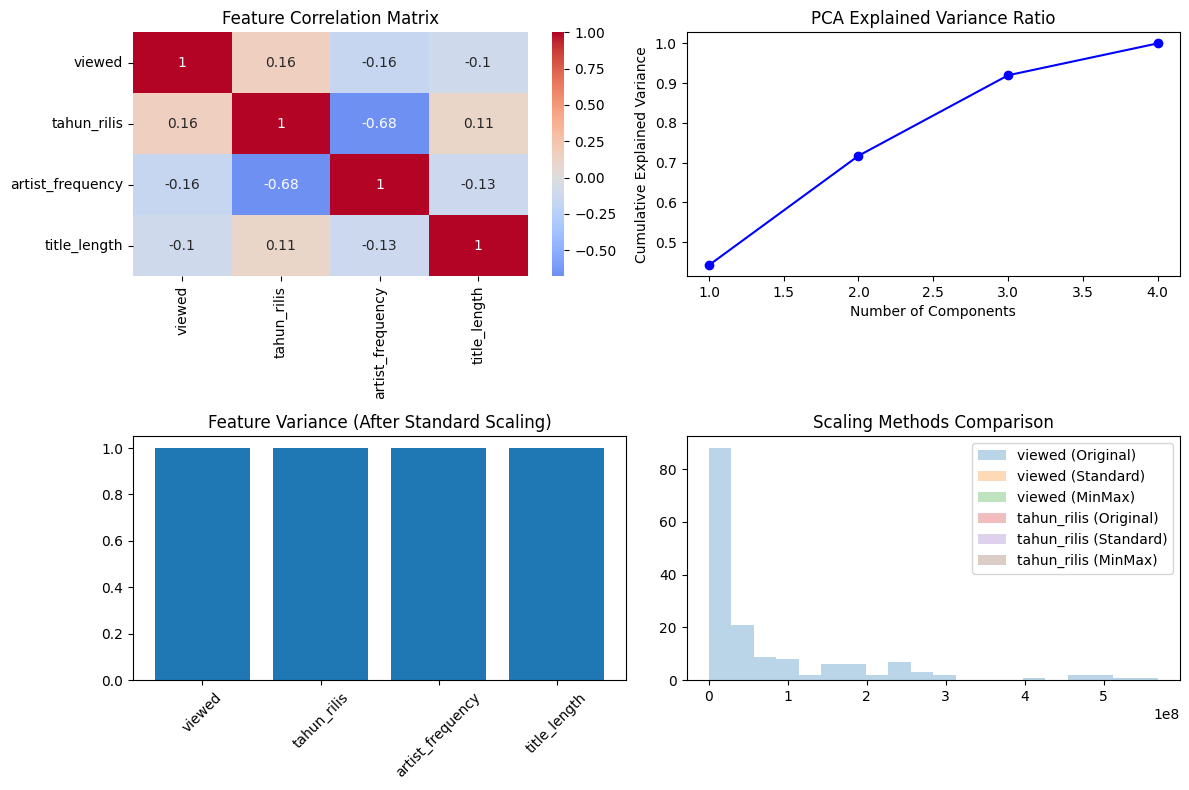

In [45]:

def similarity_analysis_prep(df):
    # Prepare numerical features
    numerical_features = ['viewed', 'tahun_rilis', 'artist_frequency', 'title_length']
    
    # Different scaling methods
    scalers = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler()
    }
    
    scaled_data = {}
    for name, scaler in scalers.items():
        scaled_data[name] = scaler.fit_transform(df[numerical_features])
    
    print("\nFeature Scaling Comparison:")
    for name, data in scaled_data.items():
        print(f"\n{name}:")
        print(f"Mean: {np.mean(data, axis=0).round(3)}")
        print(f"Std: {np.std(data, axis=0).round(3)}")
        print(f"Min: {np.min(data, axis=0).round(3)}")
        print(f"Max: {np.max(data, axis=0).round(3)}")
    
    # Distance metrics evaluation would require pairwise comparisons
    # Here we show the preparation for it
    
    # Feature correlation for dimensionality assessment
    correlation_matrix = df[numerical_features].corr()
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    
    # PCA analysis
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data['StandardScaler'])
    
    plt.subplot(2, 2, 2)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.title('PCA Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    
    # Feature importance (variance)
    plt.subplot(2, 2, 3)
    feature_variance = np.var(scaled_data['StandardScaler'], axis=0)
    plt.bar(numerical_features, feature_variance)
    plt.title('Feature Variance (After Standard Scaling)')
    plt.xticks(rotation=45)
    
    # Scaling comparison visualization
    plt.subplot(2, 2, 4)
    for i, feature in enumerate(numerical_features[:2]):  # Show first 2 features
        original = df[feature].values
        standard = scaled_data['StandardScaler'][:, i]
        minmax = scaled_data['MinMaxScaler'][:, i]
        
        plt.hist(original, alpha=0.3, label=f'{feature} (Original)', bins=20)
        plt.hist(standard, alpha=0.3, label=f'{feature} (Standard)', bins=20)
        plt.hist(minmax, alpha=0.3, label=f'{feature} (MinMax)', bins=20)
    
    plt.title('Scaling Methods Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

similarity_analysis_prep(df)


 ===============================

 6. STATISTICAL ANALYSIS

 ===============================

In [46]:
def statistical_analysis(df):
    numerical_cols = ['viewed', 'tahun_rilis']
    
    print("\n📊 Statistical Properties:")
    for col in numerical_cols:
        data = df[col].dropna()
        
        # Skewness and Kurtosis
        skew = stats.skew(data)
        kurt = stats.kurtosis(data)
        
        print(f"\n{col.upper()}:")
        print(f"  Skewness: {skew:.4f} ({'Right-skewed' if skew > 0 else 'Left-skewed' if skew < 0 else 'Symmetric'})")
        print(f"  Kurtosis: {kurt:.4f} ({'Heavy-tailed' if kurt > 0 else 'Light-tailed'})")
        
        # Normality test
        if len(data) > 8:  # KS test needs at least 8 observations
            ks_stat, ks_p = kstest(data, 'norm')
            print(f"  Normality (KS test): p-value = {ks_p:.4f} ({'Normal' if ks_p > 0.05 else 'Not Normal'})")
    
    # Variance analysis for feature selection
    print(f"\n📈 Variance Analysis:")
    for col in numerical_cols + ['artist_frequency', 'title_length']:
        if col in df.columns:
            variance = df[col].var()
            print(f"{col}: {variance:.2e}")

statistical_analysis(df)



📊 Statistical Properties:

VIEWED:
  Skewness: 2.2559 (Right-skewed)
  Kurtosis: 5.0366 (Heavy-tailed)
  Normality (KS test): p-value = 0.0000 (Not Normal)

TAHUN_RILIS:
  Skewness: -0.3677 (Left-skewed)
  Kurtosis: -1.3469 (Light-tailed)
  Normality (KS test): p-value = 0.0000 (Not Normal)

📈 Variance Analysis:
viewed: 1.36e+16
tahun_rilis: 8.40e+01
artist_frequency: 1.09e+01
title_length: 1.02e+02


 ===============================

 7. CLUSTERING ANALYSIS

 ===============================



🎯 Optimal number of clusters: 6
Best silhouette score: 0.5333

📊 Cluster Analysis:
            Avg_Views  Song_Count  Avg_Year Dominant_Genre
cluster                                                   
0        2.137434e+07          47   2024.04            pop
1        7.009392e+06          21   2006.29         reggae
2        4.879920e+08           7   2018.29            pop
3        1.348294e+07          22   2015.27         reggae
4        5.467160e+07          40   2003.78           rock
5        2.064338e+08          24   2021.54          indie

🎵 Genre vs Cluster Distribution:
cluster   0   1  2   3   4   5
genre                         
indie    18   0  2   0   0  15
pop      29   0  4   0   0   9
reggae    0  21  0  21   0   0
rock      0   0  1   1  40   0


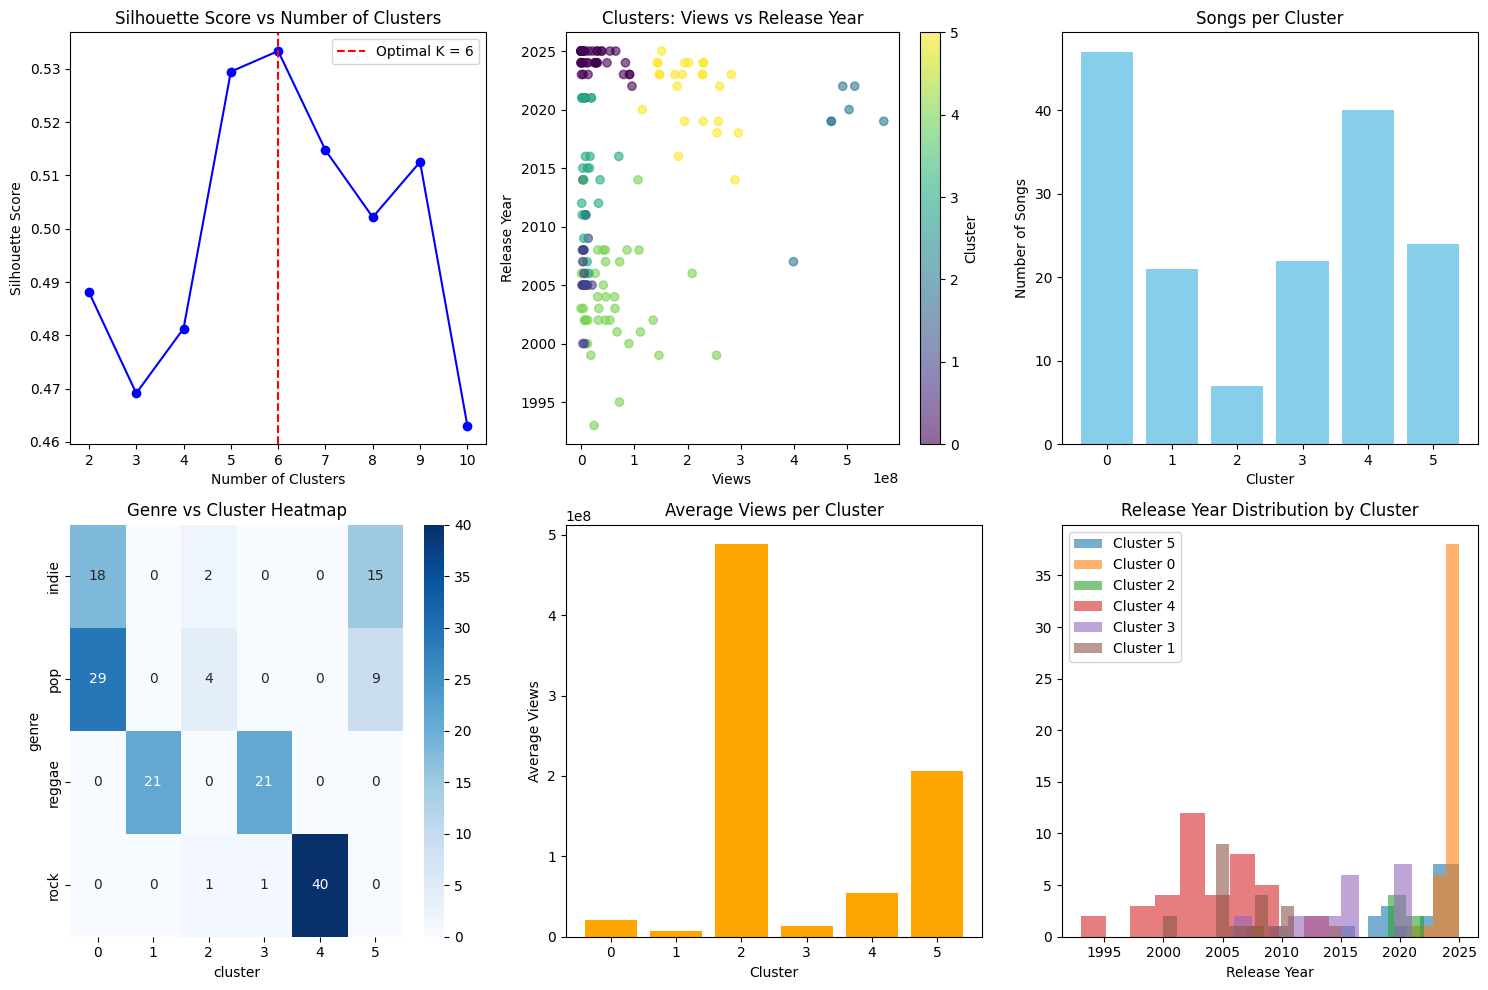

In [47]:

def clustering_analysis(df):
    # Prepare features for clustering
    features_for_clustering = ['viewed', 'tahun_rilis', 'artist_frequency', 'genre_mean_views']
    
    # Handle missing values
    clustering_data = df[features_for_clustering].fillna(df[features_for_clustering].mean())
    
    # Scale the data
    scaler = StandardScaler()
    scaled_clustering_data = scaler.fit_transform(clustering_data)
    
    # Determine optimal number of clusters
    silhouette_scores = []
    K_range = range(2, 11)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled_clustering_data)
        score = silhouette_score(scaled_clustering_data, labels)
        silhouette_scores.append(score)
    
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"\n🎯 Optimal number of clusters: {optimal_k}")
    print(f"Best silhouette score: {max(silhouette_scores):.4f}")
    
    # Perform clustering with optimal K
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['cluster'] = kmeans_optimal.fit_predict(scaled_clustering_data)
    
    # Analyze clusters
    print(f"\n📊 Cluster Analysis:")
    cluster_analysis = df.groupby('cluster').agg({
        'viewed': ['mean', 'count'],
        'tahun_rilis': 'mean',
        'genre': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'
    }).round(2)
    
    cluster_analysis.columns = ['Avg_Views', 'Song_Count', 'Avg_Year', 'Dominant_Genre']
    print(cluster_analysis)
    
    # Genre vs Cluster cross-tabulation
    print(f"\n🎵 Genre vs Cluster Distribution:")
    genre_cluster_crosstab = pd.crosstab(df['genre'], df['cluster'])
    print(genre_cluster_crosstab)
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(K_range, silhouette_scores, 'bo-')
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    
    plt.subplot(2, 3, 2)
    plt.scatter(df['viewed'], df['tahun_rilis'], c=df['cluster'], cmap='viridis', alpha=0.6)
    plt.title('Clusters: Views vs Release Year')
    plt.xlabel('Views')
    plt.ylabel('Release Year')
    plt.colorbar(label='Cluster')
    
    plt.subplot(2, 3, 3)
    cluster_counts = df['cluster'].value_counts().sort_index()
    plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
    plt.title('Songs per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Songs')
    
    plt.subplot(2, 3, 4)
    sns.heatmap(genre_cluster_crosstab, annot=True, fmt='d', cmap='Blues')
    plt.title('Genre vs Cluster Heatmap')
    
    plt.subplot(2, 3, 5)
    cluster_avg_views = df.groupby('cluster')['viewed'].mean().sort_index()
    plt.bar(cluster_avg_views.index, cluster_avg_views.values, color='orange')
    plt.title('Average Views per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Average Views')
    
    plt.subplot(2, 3, 6)
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        plt.hist(cluster_data['tahun_rilis'], alpha=0.6, label=f'Cluster {cluster}', bins=10)
    plt.title('Release Year Distribution by Cluster')
    plt.xlabel('Release Year')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

clustering_analysis(df)